## Prepare GPP from MODIS Data

In this notebook, 8-daily MODIS/Terra GPP data from 2000 - 2024 is processed. The following steps are included:
- Replace fill values with NA
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests

In [1]:
# import libraries
import os
import warnings
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# read MODIS GPP data
gpp_full = xr.open_dataset("./Raw/GPP_MODIS/MOD17A2HGF.061_500m_aid0001.nc", decode_coords="all", decode_times=True)

In [5]:
gpp_full

<xarray.Dataset>
Dimensions:      (time: 1150, lat: 1871, lon: 2203)
Coordinates:
    crs          int8 ...
  * time         (time) object 2000-01-01 00:00:00 ... 2024-12-26 00:00:00
  * lat          (lat) float64 55.06 55.06 55.05 55.05 ... 47.28 47.27 47.27
  * lon          (lon) float64 5.865 5.869 5.873 5.877 ... 15.03 15.04 15.04
Data variables:
    Gpp_500m     (time, lat, lon) float32 ...
    Psn_QC_500m  (time, lat, lon) float32 ...
Attributes:
    title:        MOD17A2HGF.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.71
    references:   See README.md
    history:      See README.md

In [6]:
# convert CFTime index to datetime index
datetimeindex = gpp_full.indexes['time'].to_datetimeindex()
gpp_full['time'] = datetimeindex

In [7]:
# rename variables
gpp_full = gpp_full.rename({"Gpp_500m":"GPP"})

In [8]:
# check crs
gpp_full.rio.crs

CRS.from_wkt('GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

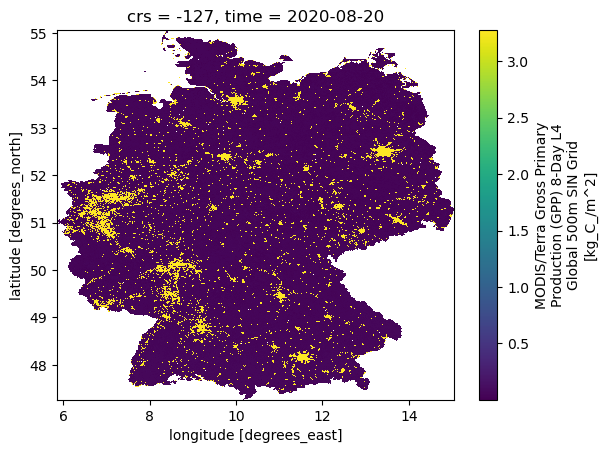

In [9]:
# plot exemplary GPP data of one date to get a first impression
gpp_full.GPP.sel(time = "2020-08-20").plot()

In [10]:
# look at attributes of GPP variable
gpp_full.GPP.attrs

{'valid_min': 0,
 'valid_max': 30000,
 'scale_factor_err': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 22,
 'long_name': 'MODIS/Terra Gross Primary Production (GPP) 8-Day L4 Global 500m SIN Grid',
 'units': 'kg_C_/m^2',
 'Gpp_FILLVALUE_DOC': 'FILL VALUE LEGEND\n32767 : _Fillvalue: not-computed or outside projection...\n32766 : water (ocean or inland)\n32765 : barren, very sparsely vegetated\n32764 : perennial snow,ice on pixel\n32763 : permanant wetlands,marshes\n32762 : urban,built-up \n32761 : unclassified\n'}

In [11]:
# in the dataset, fill values are assigned to pixels where the GPP could not be calculated
# source: https://lpdaac.usgs.gov/documents/972/MOD17_User_Guide_V61.pdf
# these pixel values should be converted to NA - this will be done in a later step because right now, the full dataset is too large for the operation

In [12]:
# for the year-end gap-filled GPP product we are using, the quality control layer can be ignored
# because LAI/FAPAR values of poor quality have already been filled
# source: https://lpdaac.usgs.gov/documents/972/MOD17_User_Guide_V61.pdf 

In [13]:
# get all dates that are stored in large dataset
dates = list(gpp_full.time.values)

In [ ]:
# loop over dates to process each date seperately
# dataset is too large to be processed at once

for d in dates:
    
    # extract gpp values of this date as xarray
    gpp = gpp_full["GPP"].sel(time = d)

    # manually get time back as dimension, not just variable
    # time dimension was dropped when selecting
    gpp = gpp.expand_dims('time')

    # replace fill value with NA
    # valid gpp range is 0 to 30000, fill value is 32761 to 32767, according to https://lpdaac.usgs.gov/documents/972/MOD17_User_Guide_V61.pdf 
    # but the scale factor of 0.0001 is automatically applied to the data, so we convert values larger than or equal to 3.2761 to NA
    gpp = xr.where((gpp < 3.2761), gpp, np.nan)

    # load forest area from ESA Landcover data for corresponding year
    # attention: forest data only available for 1992 - 2022 -> choose 2022 for gpp data of 2022 - 2024
    year = int(str(d)[0:4])

    if year >= 2022:
        forest_year = 2022
    else: forest_year = year

    forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                            decode_coords = "all", 
                            decode_times= True)
    
    # set crs for gpp data 
    gpp.rio.write_crs(4326, inplace = True)

    # set spatial dims again - otherwise resampling raises an error
    gpp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)

    # resample gpp dataset to match resolution of forest dataset
    gpp_match = gpp.rio.reproject_match(forest)

    # rename dimensions - they got renamed while resampling
    gpp_match = gpp_match.rename({'y':'lat', 'x':'lon'})

    # mask gpp with forest data
    # broadleaved forest:
    gpp_BL = gpp_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

    # needleleaved forest:
    NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
    gpp_NL = gpp_match.where(NL_mask, drop = False)

    # save as netCDF4 datasets
    date = gpp_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
    gpp_BL.to_netcdf(f"./GPP/8Daily/{year}/GPP_{date}_BL.nc")
    gpp_NL.to_netcdf(f"./GPP/8Daily/{year}/GPP_{date}_NL.nc")

In [15]:
# load one processed dataset as example and plot to get an overview
gpp_NL = xr.open_dataarray("./GPP/8Daily/2020/GPP_2020-08-20_NL.nc", decode_coords = "all", decode_times= True)
gpp_NL

<xarray.DataArray 'GPP' (lat: 2952, lon: 3510)>
[10361520 values with dtype=float32]
Coordinates:
  * lon          (lon) float64 5.451 5.454 5.457 5.46 ... 15.19 15.19 15.2 15.2
  * lat          (lat) float64 55.2 55.2 55.19 55.19 ... 47.01 47.01 47.0 47.0
    crs          int8 ...
    spatial_ref  int32 ...

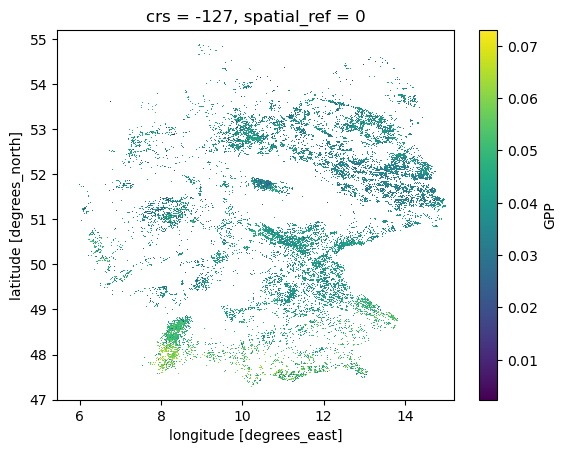

In [16]:
gpp_NL.plot()